## 📘 Training Script Overview  
This notebook trains a machine learning model using data exported from MATLAB in folder training_data 

The dataset contains the following components:

### 1. **Received Signal Components**
- `r1` — projection on basis function φ₁  
- `r2` — projection on basis function φ₂  

### 2. **Noise Parameter**
- `N0` — noise spectral density (controls SNR of the simulation)

### 3. **Transmitted Message**
- `m` — the true symbol index sent by the transmitter

### 4. **Receiver Outputs** *(not used for training)*
- `mrec_map` — symbol decisions from MAP receiver  
- `mrec_ml` — symbol decisions from ML receiver  

> ML classifier trains only on `(r1, r2)` and `m`.
> the output of model will be stored at folder model as pickle

In [19]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

# plot lib
import matplotlib.pyplot as plt
import seaborn as sns 

# ML Lib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pickle

## Combining training data for each SNR

In [2]:
current_dir = Path().resolve()
parent_dir = current_dir.parent
training_path = '%s/training_data' %parent_dir 

In [3]:
first_file = 0
for file in os.listdir(training_path):
    if first_file == 0 and '.csv' in file:
        df = pd.read_csv('%s/%s' % (training_path, file), encoding='ISO-8859-1')
        print('%s : %s' % (file, len(df)))
        first_file = 1
    elif first_file == 1 and '.csv' in file:
        df_temp = pd.read_csv('%s/%s' % (training_path, file), encoding='ISO-8859-1')
        print('%s : %s' % (file, len(df_temp)))
        df = pd.concat([df, df_temp], axis=0, ignore_index=True, sort=False)

print('             Total: %s' % len(df))

dataset_n0_0.35.csv : 10000
dataset_n0_0.20.csv : 10000
dataset_n0_0.30.csv : 10000
dataset_n0_0.25.csv : 10000
dataset_n0_0.55.csv : 10000
dataset_n0_0.40.csv : 10000
dataset_n0_0.95.csv : 10000
dataset_n0_0.80.csv : 10000
dataset_n0_0.90.csv : 10000
dataset_n0_0.85.csv : 10000
dataset_n0_0.50.csv : 10000
dataset_n0_0.45.csv : 10000
dataset_n0_0.60.csv : 10000
dataset_n0_0.75.csv : 10000
dataset_n0_0.65.csv : 10000
dataset_n0_0.70.csv : 10000
dataset_n0_0.15.csv : 10000
dataset_n0_0.05.csv : 10000
dataset_n0_0.10.csv : 10000
             Total: 190000


In [4]:
df

,m,r1,r2,mrec_map,mrec_ml,N0
0,3,0.756,-0.223,3,3,0.35
1,3,0.642,-1.344,3,3,0.35
2,0,1.249,0.624,0,0,0.35
3,0,0.847,0.385,0,0,0.35
4,1,-0.941,0.301,1,1,0.35
...,...,...,...,...,...,...
189995,3,0.839,-0.666,3,3,0.10
189996,3,1.246,-1.109,3,3,0.10
189997,0,0.657,0.378,0,0,0.10
189998,1,-0.371,0.793,1,1,0.10


## Logistic Regression Training

In [5]:
X = df[['r1', 'r2', 'N0']]
y = df[['m']]
message = df[['m']]

In [9]:
# Train and test data split
X_train, X_test, y_train, y_test, message_train, message_test = train_test_split(
    X, y, message, test_size=0.2, random_state=42
)

# Train model
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)

clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Test Accuracy:", acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Full precision/recall/F1 table
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.8894473684210527
Confusion Matrix:
[[ 1558   471     4   453]
 [  233 14224   401   326]
 [    7   664  3750   664]
 [  242   325   411 14267]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7637    0.6267    0.6885      2486
           1     0.9069    0.9368    0.9216     15184
           2     0.8213    0.7375    0.7771      5085
           3     0.9081    0.9358    0.9218     15245

    accuracy                         0.8894     38000
   macro avg     0.8500    0.8092    0.8272     38000
weighted avg     0.8866    0.8894    0.8871     38000



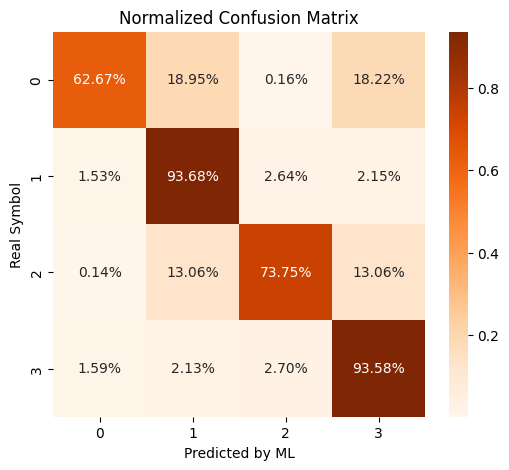

In [15]:
plt.figure(figsize=(6,5))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True),
            annot=True, fmt='.2%',
            cmap='Oranges',
            xticklabels=['0','1','2','3'],
            yticklabels=['0','1','2','3'])
plt.xlabel('Predicted by ML')
plt.ylabel('Real Symbol')
plt.title('Normalized Confusion Matrix')
plt.show()

## How to read
### Real Symbol = 0
Predicted
- 0 (62.67%) ==> Correct classification 63% of the time
- 1 (18.95%) ==> Misclassified as symbol 1 18.95%
- 2 (0.16%)  ==> Misclassified as symbol 2 0.16%
- 3 (18.22%) ==> Misclassified as symbol 3 18.22%

> So symbol 0 is mostly confused with symbol 1 and symbol 3.
----

## Save Model to Pickle

In [21]:
today_str = datetime.today().strftime('%Y%m%d')
model_path = '%s/model' %parent_dir 

# Save model
with open("%s/receiver_model_%s.pkl" %(model_path,today_str), "wb") as f:
    pickle.dump(clf, f)